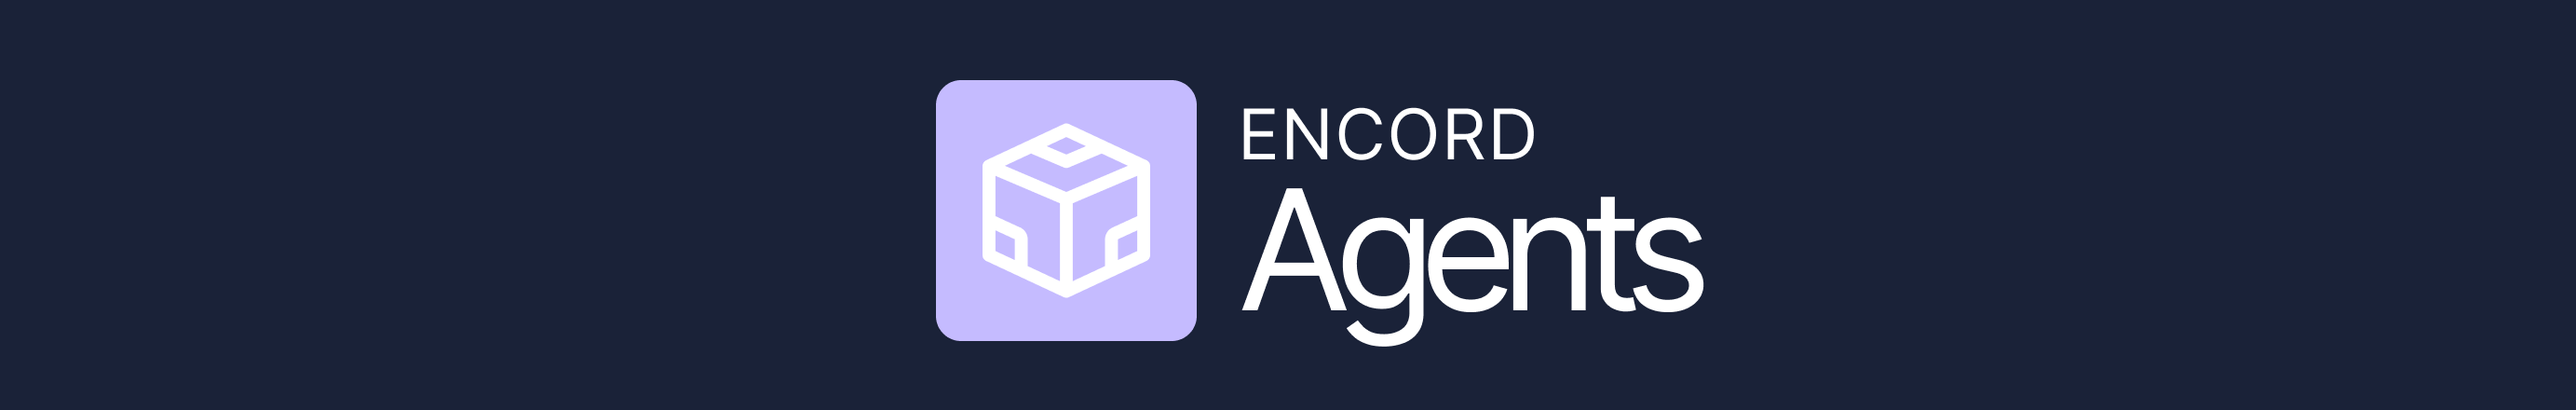


# Pre-Label Videos with Bounding Boxes

This notebook demonstrates how to use a task agent to pre-label videos with predictions. To simplify the process, we'll use "fake" predictions, though the methodology remains the same when applying the notebook with an actual model.

## Installation

Ensure that you have the `encord-agents` library installed:

In [ ]:
!python -m pip install "encord-agents[vision]"

## Authentication

The library authenticates via ssh-keys. Below, is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It should contain the raw content of your private ssh key file.

If you have not yet setup an ssh key, please follow the [documentation](https://agents-docs.encord.com/authentication/).

> 💡 **Colab users**: In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks with
> ```python
> from google.colab import userdata
> key_content = userdata.get("ENCORD_SSH_KEY")
> ```

In [ ]:
import os

os.environ["ENCORD_SSH_KEY"] = "private_key_file_content"
# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

#### [Alternative] Temporary Key
There's also the option of generating a temporary (fresh) ssh key pair via the code cell below.
Please follow the instructions printed when executing the code.

In [ ]:
# ⚠️ Safe to skip if you have authenticated already
import os

from encord_agents.utils.colab import generate_public_private_key_pair_with_instructions

private_key_path, public_key_path = generate_public_private_key_pair_with_instructions()
os.environ["ENCORD_SSH_KEY_FILE"] = private_key_path.as_posix()

## Define a _fake_ Model for Predictions

To keep things minimal, we will define a "_fake_" model which predicts labels, bounding boxes, and confidences.
We'll use the model to simulate predictiong objects on images below.

> 💡 This should be the main place for you to change code in order to integrate your own detection model.

In [ ]:
import random
from dataclasses import dataclass

import numpy as np
from encord.objects.coordinates import BoundingBoxCoordinates
from numpy.typing import NDArray


# Data class to hold predictions from our "model"
@dataclass
class ModelPrediction:
    label: int
    coords: BoundingBoxCoordinates
    conf: float


# Model "simulation"
def fake_predict(image: NDArray[np.uint8]) -> list[ModelPrediction]:
    """
    Simple function that takes in an nd array of pixel values ([h, w, c], RGB)
    And return a list of random bounding boxes. Random in location and with
    three different
    """
    return [
        ModelPrediction(
            label=random.choice(range(3)),
            coords=BoundingBoxCoordinates(
                top_left_x=random.random() * 0.5,
                top_left_y=random.random() * 0.5,
                width=random.random() * 0.5,
                height=random.random() * 0.5,
            ),
            conf=random.random(),
        )
        for _ in range(10)
    ]


model = fake_predict

## Step 3: Set up your Ontology

Create an Ontology that matches the expected output of your pre-labeling agent. 
For example, if your model predicts classes `surfboard`, `person`, and `car` with class labels 0, 1, and 2, respectively, then the ontology should look like this:

<figure style="text-align: center">
  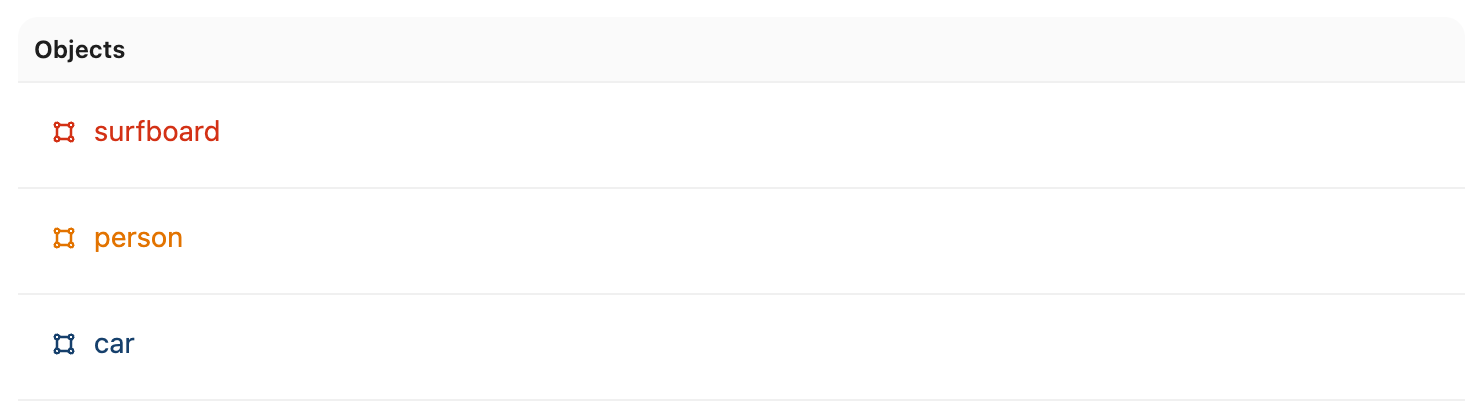
  <figcaption><stong>Figure 1:</strong> Project ontology.</figcaption>
</figure>

[📖 Here](https://docs.encord.com/platform-documentation/GettingStarted/gettingstarted-create-ontology) is the documentation for creating ontologies.

## Create a Workflow with a Pre-Labeling Agent Node

Create a Project in the Encord platform with a workflow that includes a pre-labeling agent node before the annotation stage. This node, called **"pre-label,"** runs custom code to generate model predictions, automatically pre-labeling tasks before they are sent for annotation.

[📖 Here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-workflows-and-templates#creating-workflows) is the documentation for creating Workflows in Encord.

<figure style="text-align: center">
  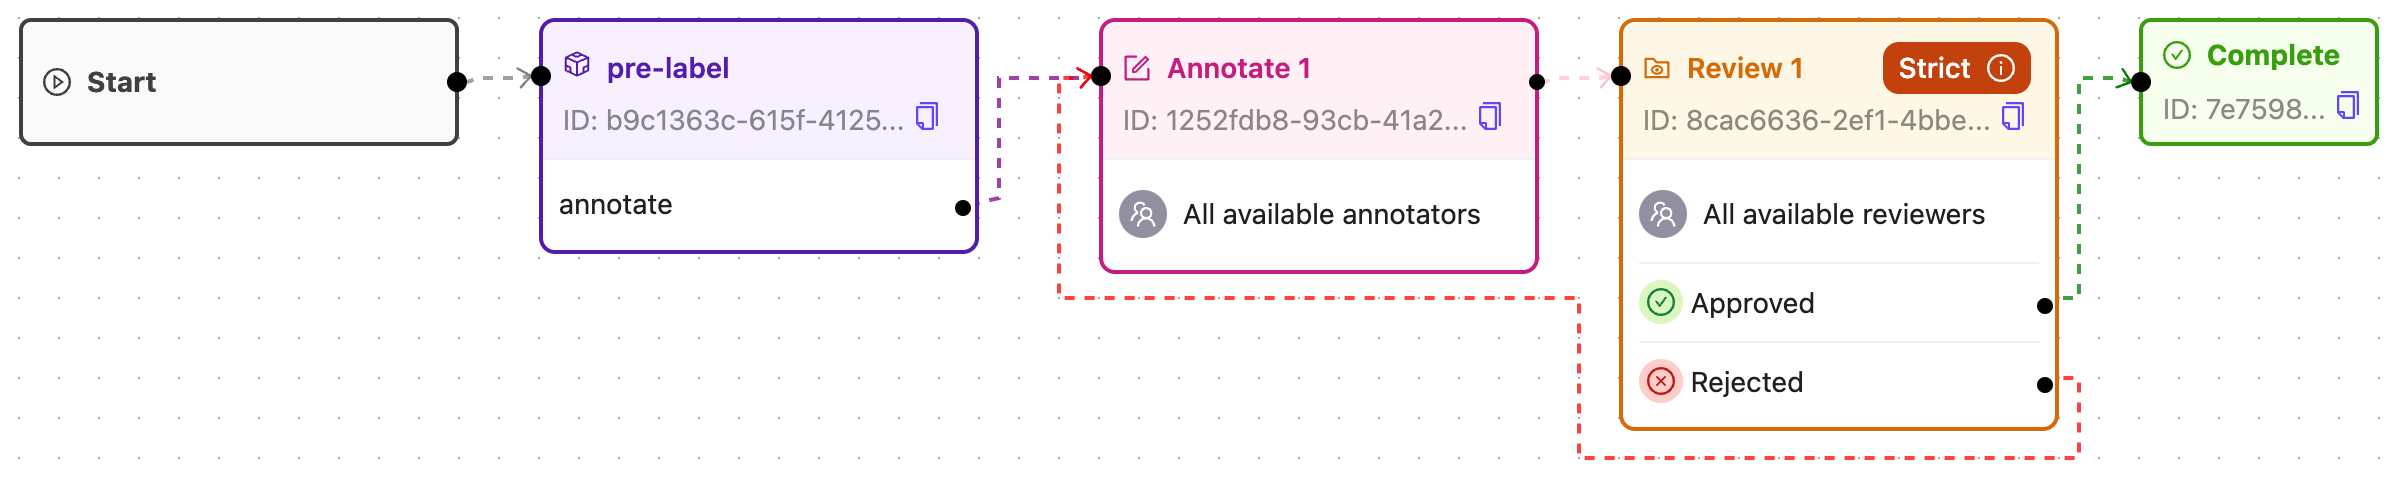
  <figcaption><strong>Figure 2:</strong> Project workflow.</figcaption>
</figure>

## Define the Pre-Labeling Agent

The following code provides a template for defining an agent that does pre-labeling.
We assume that the project only contains videos and the we want to do pre-labeling on all frames in each video.

If your agent node is named "pre-label" and the pathway to the annotation stage is named "annotate," you will only have to change the `<project_hash>` to your actual project hash to make it work.
If your naming, on the other hand, is different, then you can update the `stage` parameter of the decorator and the returned string, respectively, to comply with your own setup.

Note that this code uses the [`dep_video_iterator` dependency](../../reference/task_agents.md#encord_agents.tasks.dependencies.dep_video_iterator) to automatically load an iterator of frames as RGB numpy arrays from the video.

In [ ]:
from typing import Iterable

from encord.objects.ontology_labels_impl import LabelRowV2
from encord.project import Project
from typing_extensions import Annotated

from encord_agents.core.data_model import Frame
from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import dep_video_iterator

# a. Define a runner that will execute the agent on every task in the agent stage
runner = Runner(project_hash="<project_hash>")


# b. Specify the logic that goes into the "pre-label" agent node.
@runner.stage(stage="pre-label")
def run_something(
    lr: LabelRowV2,
    project: Project,
    frames: Annotated[Iterable[Frame], Depends(dep_video_iterator)],
) -> str:
    ontology = project.ontology_structure

    # c. Loop over the frames in the video
    for frame in frames:  # For every frame in the video
        # d. Predict  -  we could do batching here to speed up the process
        outputs = model(frame.content)

        # e. Store the results
        for output in outputs:
            ins = ontology.objects[output.label].create_instance()
            ins.set_for_frames(frames=frame.frame, coordinates=output.coords, confidence=output.conf)

            lr.add_object_instance(ins)

    lr.save()
    return "annotate"  # Tell where the task should go

## Running the Agent

The `runner` object is callable, allowing you to use it to prioritize tasks efficiently.

In [ ]:
# Run the agent
runner()

## Outcome

Your agent assigns labels to videos and routes them through the workflow to the annotation stage. As a result, each annotation task includes pre-labeled predictions.  

> 💡 To run this as a command-line interface, save the code in an `agents.py` file and replace:  
> ```python
> runner()
> ```  
> with:  
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```  
> This lets you set parameters like the project hash from the command line:  
> ```bash
> python agent.py --project-hash "..."
> ```
